In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
    f.close()
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value
        ))
    return meta_list

def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        import time
        executable_path = '/Users/waltersun/Desktop/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
    
        meta_list = [] 
        fail_list = []
        wait_time = 1
        max_try = 20
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]
                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        if tries >= max_try:
                            print('Reacheh max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                print('[{}] [Abs: {} chars, keywords: {}, ratings: {}] {}'.format(
                    i, len(abstract), len(keyword), rating, title))
                meta_list.append(PaperMeta(title, abstract, keyword, rating))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
        fail_list = []
    return meta_list, fail_list

In [3]:
# Get the meta data
# Load the data file
# meta_list, _ = crawl_meta('data.hdf5')
# Crawl data from scratch
meta_list, fail_list = crawl_meta()
print('Number of submissions: {}'.format(len(meta_list)))

[0] [Abs: 1110 chars, keywords: 3, ratings: [4, 4, 5]] Select Via Proxy: Efficient Data Selection For Training Deep Networks
[1] [Abs: 1460 chars, keywords: 3, ratings: [6, 5, 8]] Machine Translation With Weakly Paired Bilingual Documents
[2] [Abs: 1587 chars, keywords: 4, ratings: [4, 5, 3]] Layerwise Recurrent Autoencoder For General Real-world Traffic Flow Forecasting
[3] [Abs: 1275 chars, keywords: 7, ratings: [4, 3]] Rethinking Self-driving : Multi -task Knowledge For Better Generalization And Accident Explanation Ability
[4] [Abs: 889 chars, keywords: 6, ratings: [5, 5, 5]] Improving Gaussian Mixture Latent Variable Model Convergence With Optimal Transport
[5] [Abs: 1178 chars, keywords: 2, ratings: [4, 4, 8]] Neural Causal Discovery With Learnable Input Noise
[6] [Abs: 993 chars, keywords: 4, ratings: [4, 3, 4]] Hierarchical Attention: What Really Counts In Various Nlp Tasks
[7] [Abs: 1686 chars, keywords: 4, ratings: [5, 7, 4]] Convolutional Neural Networks On Non-uniform Geome

[67] [Abs: 875 chars, keywords: 3, ratings: []] Exploration In Policy Mirror Descent
[68] [Abs: 1009 chars, keywords: 0, ratings: [9, 6, 4]] Ba-net: Dense Bundle Adjustment Networks
[69] [Abs: 881 chars, keywords: 5, ratings: [3, 4]] Using Deep Siamese Neural Networks To Speed Up Natural Products Research
[70] [Abs: 1172 chars, keywords: 0, ratings: [9, 8]] Sparse Dictionary Learning By Dynamical Neural Networks
[71] [Abs: 1291 chars, keywords: 5, ratings: [6, 7, 7]] Fixing Variational Bayes: Deterministic Variational Inference For Bayesian Neural Networks
[72] [Abs: 1187 chars, keywords: 4, ratings: [6, 5, 3]] Unsupervised Disentangling Structure And Appearance
[73] [Abs: 1224 chars, keywords: 0, ratings: [4, 4, 3]] A Walk With Sgd: How Sgd Explores Regions Of Deep Network Loss?
[74] [Abs: 789 chars, keywords: 4, ratings: [9, 7, 8]] Ordered Neurons: Integrating Tree Structures Into Recurrent Neural Networks
[75] [Abs: 732 chars, keywords: 4, ratings: [4, 3, 3]] Learning And Data Selec

[136] [Abs: 1242 chars, keywords: 2, ratings: [6, 6, 6]] A Max-affine Spline Perspective Of Recurrent Neural Networks
[137] [Abs: 1561 chars, keywords: 5, ratings: [7, 7, 7]] Learning To Navigate The Web
[138] [Abs: 1039 chars, keywords: 3, ratings: [4, 7, 6]] Rotation Equivariant Networks Via Conic Convolution And The Dft
[139] [Abs: 1595 chars, keywords: 4, ratings: [4, 5, 3]] Better Accuracy With Quantified Privacy: Representations Learned Via Reconstructive Adversarial Network
[140] [Abs: 1391 chars, keywords: 2, ratings: [5, 5, 4]] Visualizing And Discovering Behavioural Weaknesses In Deep Reinforcement Learning
[141] [Abs: 850 chars, keywords: 6, ratings: [8, 7, 4]] Training For Faster Adversarial Robustness Verification Via Inducing Relu Stability
[142] [Abs: 1008 chars, keywords: 3, ratings: [6, 8, 4]] Learning To Learn With Conditional Class Dependencies
[143] [Abs: 1163 chars, keywords: 5, ratings: [3, 6, 6]] Adversarial Information Factorization
[144] [Abs: 799 chars, keywor

[204] [Abs: 772 chars, keywords: 4, ratings: [5, 8, 7]] Learning To Solve Circuit-sat: An Unsupervised Differentiable Approach
[205] [Abs: 1132 chars, keywords: 3, ratings: [7, 4]] Dynamic Channel Pruning: Feature Boosting And Suppression
[206] [Abs: 1563 chars, keywords: 5, ratings: [5, 5, 7]] Signsgd With Majority Vote Is Communication Efficient And Byzantine Fault Tolerant
[207] [Abs: 1183 chars, keywords: 4, ratings: [6, 7, 4]] Tensor Ring Nets Adapted Deep Multi-task Learning
[208] [Abs: 1180 chars, keywords: 5, ratings: [5, 7, 8]] Bounce And Learn: Modeling Scene Dynamics With Real-world Bounces
[209] [Abs: 1005 chars, keywords: 9, ratings: [7, 5, 8]] K For The Price Of 1: Parameter Efficient Multi-task And Transfer Learning
[210] [Abs: 1270 chars, keywords: 3, ratings: [4, 7]] Tangent-normal Adversarial Regularization For Semi-supervised Learning
[211] [Abs: 1136 chars, keywords: 3, ratings: [4, 4, 7]] Evading Defenses To Transferable Adversarial Examples By Mitigating Attention

[272] [Abs: 828 chars, keywords: 4, ratings: []] Neural Network Bandit Learning By Last Layer Marginalization
[273] [Abs: 1306 chars, keywords: 3, ratings: [7, 5, 5]] Optimal Transport Maps For Distribution Preserving Operations On Latent Spaces Of Generative Models
[274] [Abs: 1280 chars, keywords: 2, ratings: [4, 7]] Deep Lagrangian Networks: Using Physics As Model Prior For Deep Learning
[275] [Abs: 828 chars, keywords: 4, ratings: [4, 4, 4]] Mol-cyclegan - A Generative Model For Molecular Optimization
[276] [Abs: 807 chars, keywords: 2, ratings: [3, 3, 6]] Microgan: Promoting Variety Through Microbatch Discrimination
[277] [Abs: 1506 chars, keywords: 4, ratings: [6, 6, 6]] Accumulation Bit-width Scaling For Ultra-low Precision Training Of Deep Networks
[278] [Abs: 720 chars, keywords: 3, ratings: [7, 5, 5]] Unsupervised Learning Of Sentence Representations Using Sequence Consistency
[279] [Abs: 753 chars, keywords: 4, ratings: [5, 8, 5]] Deep Convolutional Networks As Shallow Gauss

[343] [Abs: 710 chars, keywords: 4, ratings: [4, 7, 5]] A Unified Theory Of Adaptive Stochastic Gradient Descent As Bayesian Filtering
[344] [Abs: 1314 chars, keywords: 3, ratings: [4, 7, 5, 5]] P^2ir: Universal Deep Node Representation Via Partial Permutation Invariant Set Functions
[345] [Abs: 756 chars, keywords: 4, ratings: [7]] The Role Of Over-parametrization In Generalization Of Neural Networks
[346] [Abs: 1245 chars, keywords: 7, ratings: [4, 7, 6]] Imagenet-trained Cnns Are Biased Towards Texture; Increasing Shape Bias Improves Accuracy And Robustness.
[347] [Abs: 699 chars, keywords: 1, ratings: [6, 8, 7]] Greedy Attack And Gumbel Attack: Generating Adversarial Examples For Discrete Data
[348] [Abs: 1180 chars, keywords: 2, ratings: [4, 4]] Mixture Of Pre-processing Experts Model For Noise Robust Deep Learning On Resource Constrained Platforms
[349] [Abs: 809 chars, keywords: 5, ratings: [9, 6]] Diffusion Scattering Transforms On Graphs
[350] [Abs: 998 chars, keywords: 3, rat

[408] [Abs: 1064 chars, keywords: 3, ratings: [5, 4, 4]] Efficient Sequence Labeling With Actor-critic Training
[409] [Abs: 1252 chars, keywords: 5, ratings: [9, 5, 5]] Laplacian Networks: Bounding Indicator Function Smoothness For Neural Networks Robustness
[410] [Abs: 1120 chars, keywords: 0, ratings: [4, 5, 6]] Adversarial Audio Super-resolution With Unsupervised Feature Losses
[411] [Abs: 924 chars, keywords: 4, ratings: [4, 5, 5]] Using Gans For Generation Of Realistic City-scale Ride Sharing/hailing Data Sets
[412] [Abs: 1666 chars, keywords: 4, ratings: [6, 4]] Unsupervised Meta-learning For Reinforcement Learning
[413] [Abs: 1405 chars, keywords: 3, ratings: [4, 4, 5]] Low-cost Parameterizations Of Deep Convolutional Neural Networks
[414] [Abs: 762 chars, keywords: 3, ratings: [8, 6, 6]] Stochastic Optimization Of Sorting Networks Via Continuous Relaxations
[415] [Abs: 821 chars, keywords: 6, ratings: [4, 1, 4]] Variational Autoencoders For Text Modeling Without Weakening The D

[476] [Abs: 924 chars, keywords: 2, ratings: [5, 6, 6]] Minimum Divergence Vs. Maximum Margin: An Empirical Comparison On Seq2seq Models
[477] [Abs: 768 chars, keywords: 3, ratings: [4, 4, 9]] The Problem Of Model Completion
[478] [Abs: 965 chars, keywords: 4, ratings: [7, 4, 6]] Convolutional Crfs For Semantic Segmentation
[479] [Abs: 1635 chars, keywords: 3, ratings: [5, 3, 3]] Gradmix: Multi-source Transfer Across Domains And Tasks
[480] [Abs: 914 chars, keywords: 5, ratings: [4, 4, 5]] Robust Text Classifier On Test-time Budgets
[481] [Abs: 978 chars, keywords: 3, ratings: [5, 5, 5]] Excitation Dropout: Encouraging Plasticity In Deep Neural Networks
[482] [Abs: 960 chars, keywords: 4, ratings: [6, 7, 8]] Gansynth: Adversarial Neural Audio Synthesis
[483] [Abs: 1660 chars, keywords: 4, ratings: [8, 8, 7]] Smoothing The Geometry Of Probabilistic Box Embeddings
[484] [Abs: 965 chars, keywords: 4, ratings: [4, 4, 6]] Sliced Wasserstein Auto-encoders
[485] [Abs: 916 chars, keywords: 4, 

[548] [Abs: 1275 chars, keywords: 8, ratings: [5, 5, 5]] On The Learning Dynamics Of Deep Neural Networks
[549] [Abs: 1662 chars, keywords: 0, ratings: [6, 7]] Active Learning With Partial Feedback
[550] [Abs: 969 chars, keywords: 5, ratings: [7, 9, 6]] Gradient Descent Aligns The Layers Of Deep Linear Networks
[551] [Abs: 949 chars, keywords: 0, ratings: [6, 6, 5]] Data-dependent Coresets For Compressing Neural Networks With Applications To Generalization Bounds
[552] [Abs: 1320 chars, keywords: 5, ratings: [5, 6]] Mimicking Actions Is A Good Strategy For Beginners: Fast Reinforcement Learning With Expert Action Sequences
[553] [Abs: 475 chars, keywords: 2, ratings: [4, 6]] Spread Divergences
[554] [Abs: 781 chars, keywords: 5, ratings: [6, 7, 4]] Clean-label Backdoor Attacks
[555] [Abs: 1192 chars, keywords: 4, ratings: [4, 3]] A Collaborative Low-rank Reconstructive Layer For Domain Shift Problems
[556] [Abs: 826 chars, keywords: 2, ratings: [4, 2, 6]] Revisting Negative Transfer Us

[616] [Abs: 1130 chars, keywords: 3, ratings: [4, 6, 5]] Pyramid Recurrent Neural Networks For Multi-scale Change-point Detection
[617] [Abs: 1629 chars, keywords: 3, ratings: [4, 4, 3]] Improving Adversarial Discriminative Domain Adaptation
[618] [Abs: 1478 chars, keywords: 6, ratings: [6, 5, 5]] Generalization And Regularization In Dqn
[619] [Abs: 1500 chars, keywords: 4, ratings: [4, 5, 5]] Batch Normalization Sampling
[620] [Abs: 869 chars, keywords: 2, ratings: [6, 6]] Datnet: Dual Adversarial Transfer For Low-resource Named Entity Recognition
[621] [Abs: 1305 chars, keywords: 3, ratings: [3, 4, 3]] Multi-scale Stacked Hourglass Network For Human Pose Estimation
[622] [Abs: 1014 chars, keywords: 5, ratings: [5, 4, 6]] On Regularization And Robustness Of Deep Neural Networks
[623] [Abs: 1212 chars, keywords: 5, ratings: [5, 6, 8]] Principled Deep Neural Network Training Through Linear Programming
[624] [Abs: 1418 chars, keywords: 3, ratings: [8, 7, 8]] Learning Unsupervised Learnin

[684] [Abs: 577 chars, keywords: 1, ratings: [5, 6, 6]] Super-resolution Via Conditional Implicit Maximum Likelihood Estimation
[685] [Abs: 1361 chars, keywords: 5, ratings: [5, 4, 4]] The Cakewalk Method
[686] [Abs: 555 chars, keywords: 5, ratings: [6, 6, 3]] Improved Robustness To Adversarial Examples Using Lipschitz Regularization Of The Loss
[687] [Abs: 1113 chars, keywords: 4, ratings: [5, 6]] Accelerated Gradient Flow For Probability Distributions
[688] [Abs: 1100 chars, keywords: 2, ratings: [5, 3, 5]] Variational Recurrent Models For Representation Learning
[689] [Abs: 888 chars, keywords: 3, ratings: [6, 6, 3]] Towards Gan Benchmarks Which Require Generalization
[690] [Abs: 1208 chars, keywords: 2, ratings: [6, 6, 6]] A Closer Look At Few-shot Classification
[691] [Abs: 1604 chars, keywords: 3, ratings: [8, 5]] An Alarm System For Segmentation Algorithm Based On Shape Model
[692] [Abs: 1848 chars, keywords: 4, ratings: [6, 6, 4]] Estimating Information Flow In Dnns
[693] [Abs:

[753] [Abs: 1062 chars, keywords: 4, ratings: [5, 4]] Pruning With Hints: An Efficient Framework For Model Acceleration
[754] [Abs: 614 chars, keywords: 0, ratings: [6, 5, 7]] Temporal Gaussian Mixture Layer For Videos
[755] [Abs: 1106 chars, keywords: 5, ratings: [7, 6, 7]] Solving The Rubik's Cube With Approximate Policy Iteration
[756] [Abs: 1124 chars, keywords: 3, ratings: [4, 5, 4]] Nice: Noise Injection And Clamping Estimation For Neural Network Quantization
[757] [Abs: 1037 chars, keywords: 5, ratings: [9, 4]] Variance Reduction For Reinforcement Learning In Input-driven Environments
[758] [Abs: 2139 chars, keywords: 4, ratings: [5, 3, 4]] Learning Latent Semantic Representation From Pre-defined Generative Model
[759] [Abs: 1035 chars, keywords: 2, ratings: [6, 5, 6]] Transferring Knowledge Across Learning Processes
[760] [Abs: 1154 chars, keywords: 0, ratings: [6, 5, 7]] Model-predictive Policy Learning With Uncertainty Regularization For Driving In Dense Traffic
[761] [Abs: 1

[821] [Abs: 1761 chars, keywords: 6, ratings: [6, 6, 7]] Universal Transformers
[822] [Abs: 1442 chars, keywords: 4, ratings: [2, 6]] Learning To Adapt In Dynamic, Real-world Environments Through Meta-reinforcement Learning
[823] [Abs: 718 chars, keywords: 0, ratings: [7, 5, 4]] Unseen Action Recognition With Multimodal Learning
[824] [Abs: 1111 chars, keywords: 3, ratings: [5, 5, 5]] Weakly-supervised Knowledge Graph Alignment With Adversarial Learning
[825] [Abs: 1128 chars, keywords: 2, ratings: [7, 7, 5]] L-shapley And C-shapley: Efficient Model Interpretation For Structured Data
[826] [Abs: 1045 chars, keywords: 4, ratings: [3, 4]] The Forward-backward Embedding Of Directed Graphs
[827] [Abs: 880 chars, keywords: 2, ratings: [6, 5, 6]] Discovery Of Natural Language Concepts In Individual Units
[828] [Abs: 1628 chars, keywords: 5, ratings: [7, 7, 6]] Towards The First Adversarially Robust Neural Network Model On Mnist
[829] [Abs: 788 chars, keywords: 2, ratings: [4, 4, 4]] Activity

[890] [Abs: 782 chars, keywords: 5, ratings: [3, 7]] Arm: Augment-reinforce-merge Gradient For Stochastic Binary Networks
[891] [Abs: 949 chars, keywords: 4, ratings: [6, 6, 7]] Building Dynamic Knowledge Graphs From Text Using Machine Reading Comprehension
[892] [Abs: 768 chars, keywords: 3, ratings: [4, 3, 3]] Accidental Explorationa Through Value Predictors
[893] [Abs: 1054 chars, keywords: 3, ratings: [7, 5, 7]] Information Asymmetry In Kl-regularized Rl
[894] [Abs: 1107 chars, keywords: 4, ratings: [4, 7, 8]] Timbretron: A Wavenet(cyclegan(cqt(audio))) Pipeline For Musical Timbre Transfer
[895] [Abs: 813 chars, keywords: 3, ratings: [4, 6, 4]] Stability Of Stochastic Gradient Method With Momentum For Strongly Convex Loss Functions
[896] [Abs: 948 chars, keywords: 3, ratings: [5, 7, 5]] Whitening And Coloring Transform For Gans
[897] [Abs: 1026 chars, keywords: 7, ratings: [4, 4, 6]] Differentiable Expected Bleu For Text Generation
[898] [Abs: 806 chars, keywords: 4, ratings: [8, 9

[958] [Abs: 842 chars, keywords: 4, ratings: [5, 3, 6]] Exploiting Environmental Variation To Improve Policy Robustness In Reinforcement Learning
[959] [Abs: 702 chars, keywords: 4, ratings: [6, 2]] Learning Programmatically Structured Representations With Perceptor Gradients
[960] [Abs: 985 chars, keywords: 0, ratings: [2, 2, 4]] Multiple Encoder-decoders Net For Lane Detection
[961] [Abs: 992 chars, keywords: 4, ratings: [4, 7, 4]] Learning And Planning With A Semantic Model
[962] [Abs: 991 chars, keywords: 2, ratings: [6, 4, 5]] Variational Autoencoders With Jointly Optimized Latent Dependency Structure
[963] [Abs: 975 chars, keywords: 5, ratings: [5, 6, 5]] The Unusual Effectiveness Of Averaging In Gan Training
[964] [Abs: 1297 chars, keywords: 4, ratings: [4, 4, 5]] A Single Shot Pca-driven Analysis Of Network Structure To Remove Redundancy
[965] [Abs: 830 chars, keywords: 5, ratings: [6, 3, 5]] Tfgan: Improving Conditioning For Text-to-video Synthesis
[966] [Abs: 1285 chars, keyw

[1025] [Abs: 1259 chars, keywords: 3, ratings: [5, 6, 5]] Probabilistic Model-based Dynamic Architecture Search
[1026] [Abs: 1739 chars, keywords: 8, ratings: [3, 4, 5]] Robustness And Equivariance Of Neural Networks
[1027] [Abs: 962 chars, keywords: 7, ratings: [6, 4, 5]] Poincare Glove: Hyperbolic Word Embeddings
[1028] [Abs: 1198 chars, keywords: 4, ratings: [3, 3]] Real-time Neural-based Input Method
[1029] [Abs: 1052 chars, keywords: 4, ratings: [6, 5, 4]] Graph2seq: Scalable Learning Dynamics For Graphs
[1030] [Abs: 1283 chars, keywords: 3, ratings: [4, 5, 5]] Variational Sparse Coding
[1031] [Abs: 1486 chars, keywords: 5, ratings: [6, 4, 7]] Episodic Curiosity Through Reachability
[1032] [Abs: 1316 chars, keywords: 3, ratings: [6, 3, 4]] Representation Compression And Generalization In Deep Neural Networks
[1033] [Abs: 843 chars, keywords: 4, ratings: [4, 5]] Combining Learned Representations For Combinatorial Optimization
[1034] [Abs: 1264 chars, keywords: 4, ratings: [6, 7, 7]

[1094] [Abs: 677 chars, keywords: 0, ratings: [5, 5, 4]] Online Bellman Residue Minimization Via Saddle Point Optimization
[1095] [Abs: 877 chars, keywords: 3, ratings: [7, 7, 7]] Cot: Cooperative Training For Generative Modeling Of Discrete Data
[1096] [Abs: 1456 chars, keywords: 2, ratings: [5, 6, 7]] Graph Convolutional Network With Sequential Attention For Goal-oriented Dialogue Systems
[1097] [Abs: 1356 chars, keywords: 10, ratings: [4, 3, 4]] Visualizing And Understanding The Semantics Of Embedding Spaces Via Algebraic Formulae
[1098] [Abs: 1519 chars, keywords: 4, ratings: [4, 3, 4]] Diminishing Batch Normalization
[1099] [Abs: 1185 chars, keywords: 3, ratings: [3, 3, 4]] Beyond Games: Bringing Exploration To Robots In Real-world
[1100] [Abs: 764 chars, keywords: 3, ratings: [4, 4]] No Pressure! Addressing Problem Of Local Minima In Manifold Learning
[1101] [Abs: 1018 chars, keywords: 4, ratings: [5, 5, 5]] Dataset Distillation
[1102] [Abs: 1241 chars, keywords: 4, ratings: [3, 

[1163] [Abs: 1846 chars, keywords: 3, ratings: [8, 6, 5]] Universal Stagewise Learning For Non-convex Problems With Convergence On Averaged Solutions
[1164] [Abs: 1299 chars, keywords: 3, ratings: [8, 4, 9]] Invariant And Equivariant Graph Networks
[1165] [Abs: 1281 chars, keywords: 3, ratings: [2]] A Case Study On Optimal Deep Learning Model For Uavs
[1166] [Abs: 871 chars, keywords: 4, ratings: [6, 7, 8]] Robustness May Be At Odds With Accuracy
[1167] [Abs: 1441 chars, keywords: 6, ratings: [6, 5, 6]] Zero-resource Multilingual Model Transfer: Learning What To Share
[1168] [Abs: 1212 chars, keywords: 3, ratings: [5, 5, 7]] Attentive Task-agnostic Meta-learning For Few-shot Text Classification
[1169] [Abs: 1099 chars, keywords: 3, ratings: [3, 7, 5]] Cohen Welling Bases & So(2)-equivariant Classifiers Using Tensor Nonlinearity.
[1170] [Abs: 601 chars, keywords: 5, ratings: [6, 7]] Invariance And Inverse Stability Under Relu
[1171] [Abs: 2030 chars, keywords: 3, ratings: [5, 9, 7]] Fea

[1232] [Abs: 937 chars, keywords: 3, ratings: [4]] Sample-efficient Policy Learning In Multi-agent Reinforcement Learning Via Meta-learning
[1233] [Abs: 1291 chars, keywords: 3, ratings: []] Neural Collobrative Networks
[1234] [Abs: 837 chars, keywords: 3, ratings: [6, 5, 4]] Using Ontologies To Improve Performance In Massively Multi-label Prediction
[1235] [Abs: 1120 chars, keywords: 4, ratings: [6, 6]] Characterizing Audio Adversarial Examples Using Temporal Dependency
[1236] [Abs: 564 chars, keywords: 3, ratings: [1, 1, 5]] Advanced Neuroevolution: A Gradient-free Algorithm To Train Deep Neural Networks
[1237] [Abs: 1018 chars, keywords: 2, ratings: [5, 6, 4]] Mlprune: Multi-layer Pruning For Automated Neural Network Compression
[1238] [Abs: 844 chars, keywords: 3, ratings: [5, 4, 6]] Label Propagation Networks
[1239] [Abs: 641 chars, keywords: 4, ratings: [6, 5, 5]] Equi-normalization Of Neural Networks
[1240] [Abs: 1308 chars, keywords: 3, ratings: [6, 6, 4]] Hint-based Training F

[1300] [Abs: 1306 chars, keywords: 4, ratings: [4, 8, 4]] A Deep Learning Approach For Dynamic Survival Analysis With Competing Risks
[1301] [Abs: 793 chars, keywords: 3, ratings: [4, 4]] Explaining Alphago: Interpreting Contextual Effects In Neural Networks
[1302] [Abs: 914 chars, keywords: 3, ratings: [5, 3, 7]] On Accurate Evaluation Of Gans For Language Generation
[1303] [Abs: 1150 chars, keywords: 0, ratings: [6, 6, 7]] On Computation And Generalization Of Generative Adversarial Networks Under Spectrum Control
[1304] [Abs: 1255 chars, keywords: 7, ratings: [6, 9, 7]] Large-scale Study Of Curiosity-driven Learning
[1305] [Abs: 924 chars, keywords: 4, ratings: [7, 3, 3]] Deep Perm-set Net: Learn To Predict Sets With Unknown Permutation And Cardinality Using Deep Neural Networks
[1306] [Abs: 1178 chars, keywords: 5, ratings: [7, 7, 9]] Slalom: Fast, Verifiable And Private Execution Of Neural Networks In Trusted Hardware
[1307] [Abs: 724 chars, keywords: 2, ratings: [3, 3, 2]] Exponen

[1366] [Abs: 603 chars, keywords: 3, ratings: [4, 4, 3]] Inhibited Softmax For Uncertainty Estimation In Neural Networks
[1367] [Abs: 989 chars, keywords: 6, ratings: [6, 5, 5]] Knows When It Doesn’t Know: Deep Abstaining Classifiers
[1368] [Abs: 959 chars, keywords: 7, ratings: [6, 7, 7]] Hyperbolic Attention Networks
[1369] [Abs: 1506 chars, keywords: 5, ratings: [5, 5, 7]] Nested Dithered Quantization For Communication Reduction In Distributed Training
[1370] [Abs: 853 chars, keywords: 3, ratings: [4, 5, 4]] Learning Hash Codes Via Hamming Distance Targets
[1371] [Abs: 1114 chars, keywords: 4, ratings: [3, 5, 6]] Sentence Encoding With Tree-constrained Relation Networks
[1372] [Abs: 1219 chars, keywords: 5, ratings: [4, 3, 2]] A Forensic Representation To Detect Non-trivial Image Duplicates, And How It Applies To Semantic Segmentation
[1373] [Abs: 800 chars, keywords: 3, ratings: [7, 4, 5]] Aim: Adversarial Inference By Matching Priors And Conditionals
[1374] [Abs: 1194 chars, keywo

[1433] [Abs: 1317 chars, keywords: 3, ratings: [4, 4, 4]] Exploiting Invariant Structures For Compression In Neural Networks
[1434] [Abs: 1617 chars, keywords: 1, ratings: [4, 3, 3]] She2: Stochastic Hamiltonian Exploration And Exploitation For Derivative-free Optimization
[1435] [Abs: 870 chars, keywords: 5, ratings: [3, 3, 4]] Understanding And Improving Sequence-labeling Ner With Self-attentive Lstms
[1436] [Abs: 1140 chars, keywords: 4, ratings: [6, 4, 3]] Learning Corresponded Rationales For Text Matching
[1437] [Abs: 1214 chars, keywords: 4, ratings: [4, 3, 8]] Geomstats: A Python Package For Riemannian Geometry In Machine Learning
[1438] [Abs: 804 chars, keywords: 2, ratings: [7, 8, 6]] Learning Neural Pde Solvers With Convergence Guarantees
[1439] [Abs: 1396 chars, keywords: 3, ratings: [3, 6, 4]] Robust Determinantal Generative Classifier For Noisy Labels And Adversarial Attacks
[1440] [Abs: 836 chars, keywords: 0, ratings: [6, 5, 4]] Reinforced Imitation Learning From Observa

[1501] [Abs: 1655 chars, keywords: 5, ratings: [4, 5, 5]] Conditional Network Embeddings
[1502] [Abs: 1395 chars, keywords: 5, ratings: [6, 7]] Defensive Quantization: When Efficiency Meets Robustness
[1503] [Abs: 1651 chars, keywords: 0, ratings: [5, 4, 5]] Characterizing Vulnerabilities Of Deep Reinforcement Learning
[1504] [Abs: 1894 chars, keywords: 4, ratings: [5, 4, 3]] On The Statistical And Information Theoretical Characteristics Of Dnn Representations
[1505] [Abs: 1098 chars, keywords: 11, ratings: [6, 7, 6]] Go Gradient For Expectation-based Objectives
[1506] [Abs: 1099 chars, keywords: 4, ratings: [5, 6, 5]] H-detach: Modifying The Lstm Gradient Towards Better Optimization
[1507] [Abs: 1489 chars, keywords: 3, ratings: [4, 4]] Fatty And Skinny: A Joint Training Method Of Watermark Encoder And Decoder
[1508] [Abs: 1629 chars, keywords: 5, ratings: [8, 7, 6]] An Analytic Theory Of Generalization Dynamics And Transfer Learning In Deep Linear Networks
[1509] [Abs: 772 chars, key

[1571] [Abs: 1124 chars, keywords: 2, ratings: [5, 8]] Deep Layers As Stochastic Solvers
[1572] [Abs: 1040 chars, keywords: 1, ratings: [4, 5, 5]] Accelerated Sparse Recovery Under Structured Measurements
[1573] [Abs: 825 chars, keywords: 3, ratings: [6, 7, 5]] Hierarchical Reinforcement Learning With Limited Policies And Hindsight
Number of submissions: 1574


In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 5.14517625231911


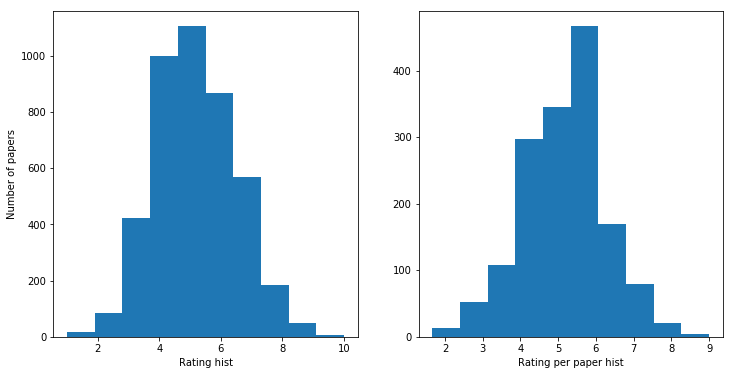

In [5]:
# Plot histograms of ratings
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(rating, bins=10)
plt.xlabel('Rating hist')
plt.ylabel('Number of papers')
plt.subplot(122)
plt.hist(rating_mean, bins=10)
plt.xlabel('Rating per paper hist')
plt.show()

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating >= np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (5+6+7)/3  # your average rating here
print('Your papar beats {:.2f}% of submission '
      '(well, jsut based on the ratings...)'.format(PR(rating_mean, my_rating)))


# ICLR 2017: accept rate 39.1% (198/507) (15 orals and 183 posters)
# ICLR 2018: accept rate 32% (314/981) (23 orals and 291 posters)
# ICLR 2018: accept rate ?% (?/1580)

Your papar beats 82.35% of submission (well, jsut based on the ratings...)


In [7]:
# Count keywords
from collections import Counter
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
# print('Merge: {}'.format([d+'s' for d in duplicates]))
print('{} different keywords after merging'.format(len(keywords_hist)))

2858 different keywords before merging
2756 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

66


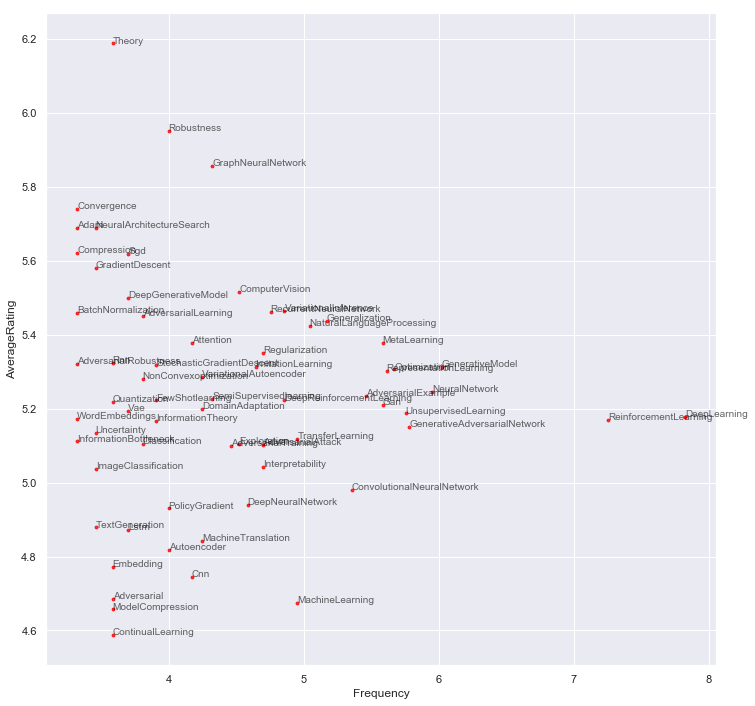

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
'Frequency': x,
'AverageRating': y,
'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

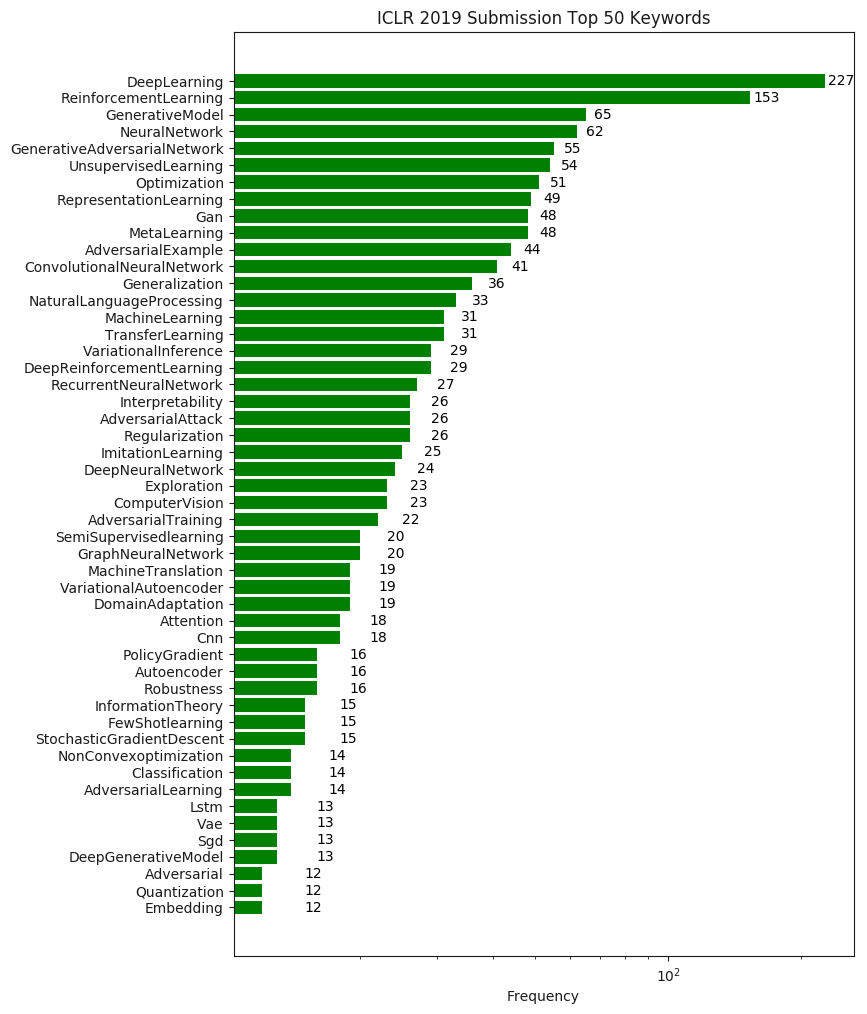

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

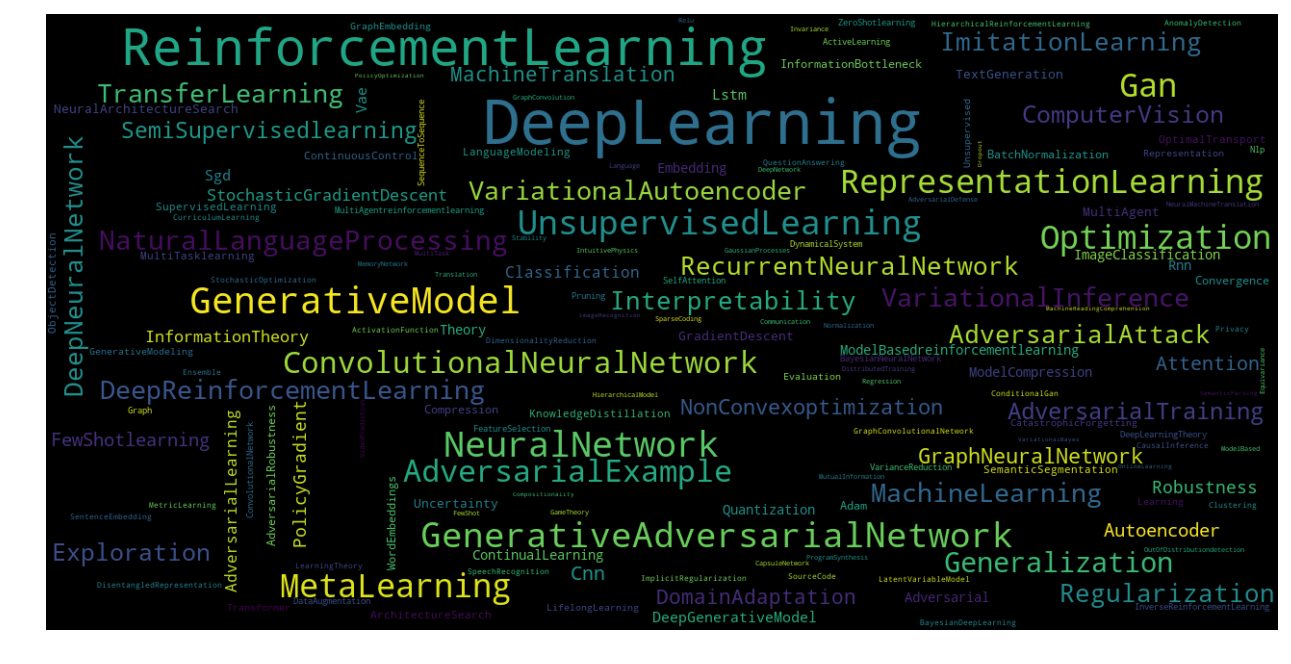

In [11]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

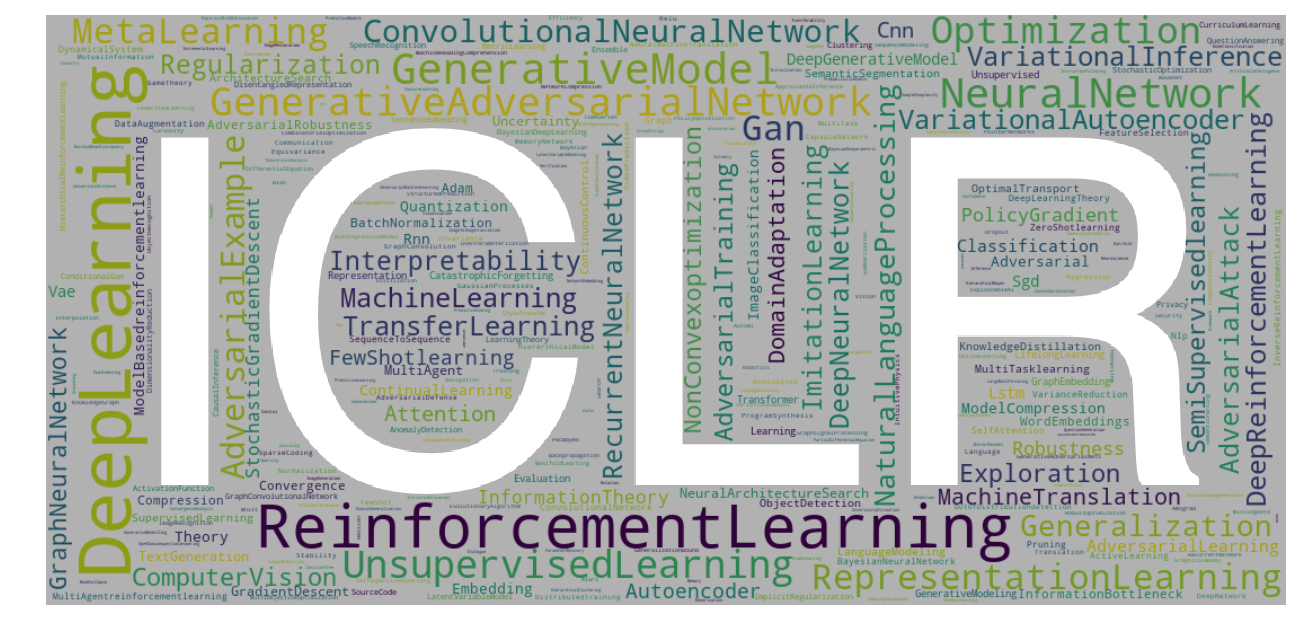

In [12]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [13]:
missing_rating = np.sum(3-np.clip(num_rating, 0, 3))
print('Number of miss reviews: {} ({:.4f}%)'.format(
    missing_rating, 100*float(missing_rating)/(len(meta_list)*3)))

Number of miss reviews: 413 (8.7463%)
